# p8 POC - Utiliser un SLM (Phi 3.5) pour faire de la classification en zero ou few-shot

On redigera une note methodologique, mais bien noter l'interet metier:

- possible de modifier la grille de classif en fonction des besoins (alors que modele BERT necessiterait re-entrainement)
- possible de faire de la classif sans avoir des donnees annotees (pertinent pour site de ecommerce par exemple)

## Organisation

On va charger un phi3 comme basemodel, et reprendre les donnees utilisees dans le p6 "Classifiez automatiquement des biens de consommation".

- On reprend le preprocessing: extraction des labels a partir du CSV pour obtenir les `7` categories principales
- On ne fait pas de stemming/lemmatization pour ces gros modeles (l'interet justement pour le POC de montrer que l'on aurait pas besoin de faire des traitements differents en fonction des fournisseurs, bases de donnees etc.)

## Technos

Chargement du basemodel depuis le hub HuggingFace.

- On retiendra un modele 3B car on peut le faire tourner en full precision sur les GPUs Kaggle par ex.
- GPU utilise: GPU T4 x2

---

In [1]:
!pip install outlines==0.0.46

In [2]:
import os
import sys
import json
import yaml
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_columns', None)

# 1. Import des donnees et pre-traitement

In [4]:
df = pd.read_csv("/kaggle/input/flipkart/Flipkart/flipkart_com-ecommerce_sample_1050.csv")

In [5]:
df.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."


## 1.1 Analyse exploratoire

- Deja fait pour le p6, il n'y a pas de doublon/valeurs manquantes etc.
- Sur les 1050 objets il y en a 150 dans chacune des 7 categories principales
- On peut directement aller extraire les categories principales

## 1.2 Extraction de la categorie principale

In [6]:
df.loc[:4, "product_category_tree"]

0    ["Home Furnishing >> Curtains & Accessories >>...
1    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2    ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3    ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4    ["Home Furnishing >> Bed Linen >> Bedsheets >>...
Name: product_category_tree, dtype: object

In [7]:
get_main_category = lambda example: re.findall("^.+?(?= >>|$)", example)[0][2:] # wanted to practice regex but this includes the [" chars at the start of string O_o hence the [2:] to drop them

df["main_product_category"] = df["product_category_tree"].apply(get_main_category)

In [8]:
pd.DataFrame(df["main_product_category"].value_counts())

,count
main_product_category,
Home Furnishing,150
Baby Care,150
Watches,150
Home Decor & Festive Needs,150
Kitchen & Dining,150
Beauty and Personal Care,150
Computers,150


## 1.3 Creation dataframe simplifiee

In [9]:
df1 = df[["uniq_id","product_name", "description", "main_product_category"]].copy()

df1.head(2)

,uniq_id,product_name,description,main_product_category
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care


## 1.4 Creation liste des product category

- On s'en servira avec Outlines

In [10]:
MAIN_PRODUCT_CATEGORIES = list(df["main_product_category"].unique())

print(MAIN_PRODUCT_CATEGORIES, type(MAIN_PRODUCT_CATEGORIES))

['Home Furnishing', 'Baby Care', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Computers'] <class 'list'>


# 2. Chargement modele

In [11]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, set_seed

In [12]:
RANDOM_SEED = 123
set_seed(123)

## 2.1 Log infos GPU

- On fait l'inference avec compte Kaggle

In [13]:
# GPU check
torch.cuda.is_available()

True

In [14]:
!nvidia-smi

Fri Jan 24 17:21:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2.2 Chargement modele

In [15]:
MODEL_PATH_OR_DIR = "microsoft/Phi-3.5-mini-instruct"

In [16]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH_OR_DIR, 
    device_map="auto", 
    torch_dtype="auto", 
    trust_remote_code=True, 
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH_OR_DIR)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
!nvidia-smi

Fri Jan 24 17:21:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P0             26W /   70W |    3749MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2.3 Creation pipeline

In [18]:
classifier = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

Device set to use cuda:0


In [19]:
from outlines.integrations.transformers import JSONPrefixAllowedTokens
from pydantic import BaseModel, Field
from typing import Literal

class ProductCategoryExtractor(BaseModel):
    product_category: Literal['Home Furnishing', 'Baby Care', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Computers'] = Field(description="The general category that is the best description for the product on an ecommerce site.")

prefix_allowed_tokens_fn = JSONPrefixAllowedTokens(
    schema=ProductCategoryExtractor,
    tokenizer_or_pipe=classifier, # our previously defined phi3.5 classifier pipeline
)

Compiling FSM index for all state transitions: 100%|██████████| 112/112 [00:00<00:00, 117.77it/s]


In [20]:
prompt_zero_shot = """Read carefully the following product name, and product description.

Product name: {product_name}

Product description: {product_description}

Now based on this information only, classify the above product into one of the following categories:

- Home Furnishing
- Baby Care
- Watches
- Home Decor & Festive Needs
- Kitchen & Dining
- Beauty and Personal Care
- Computers
"""

In [21]:
# get a sample name and description

test_name = df1.loc[721]["product_name"]
test_description = df1.loc[721]["description"]
test_gold_answer = df1.loc[721]["main_product_category"]

print(test_name)
print("---")
print(test_description)
print("===")
print(test_gold_answer)

SPANGLE Floral King Blanket CC0070001
---
SPANGLE Floral King Blanket CC0070001 (Mink Blanket, Blanket With Storage Bag)
                         Price: Rs. 1,100
				
			Soft Mink Blanket Made of Yarn to Keep You Warm
Soft Mink Blanket Made of Yarn to Keep You Warm
===
Home Furnishing


In [22]:
prompt = prompt_zero_shot.format(product_name=test_name,
                                product_description=test_description)

print("==== Inspect prompt to make sure it looks OK ====")
print(prompt)
print("=================================================")

messages = [ 
    {"role": "system", "content": "You are an ecommerce product analyst"}, 
    {"role": "user", "content": prompt}, 
] 

==== Inspect prompt to make sure it looks OK ====
Read carefully the following product name, and product description.

Product name: SPANGLE Floral King Blanket CC0070001

Product description: SPANGLE Floral King Blanket CC0070001 (Mink Blanket, Blanket With Storage Bag)
                         Price: Rs. 1,100
				
			Soft Mink Blanket Made of Yarn to Keep You Warm
Soft Mink Blanket Made of Yarn to Keep You Warm

Now based on this information only, classify the above product into one of the following categories:

- Home Furnishing
- Baby Care
- Watches
- Home Decor & Festive Needs
- Kitchen & Dining
- Beauty and Personal Care
- Computers



In [23]:
structured_generation_args = { 
    "max_new_tokens": 500, 
    "return_full_text": False, 
    "temperature": 0.0,
    "prefix_allowed_tokens_fn": prefix_allowed_tokens_fn,
}

structured_output = classifier(messages, **structured_generation_args)

structured_output

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48


[{'generated_text': '{ "product_category": "Home Furnishing" }'}]

# 3. Faire l'inference sur le dataset

## 3.1 Split pour comparaison BERT

On va prendre un split stratifie pour faire les tests avec Phi3.5, ainsi on pourra entrainer un BERT et faire l'eval sur le meme jeu de test, afin d'avoir une comparaison

In [24]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df1,
    test_size=0.2,
    stratify=df1["main_product_category"]
)

#### Verifier que la stratification fonctionne

In [25]:
pd.DataFrame(df_train["main_product_category"].value_counts())

,count
main_product_category,
Computers,120
Watches,120
Beauty and Personal Care,120
Home Furnishing,120
Home Decor & Festive Needs,120
Kitchen & Dining,120
Baby Care,120


In [26]:
pd.DataFrame(df_test["main_product_category"].value_counts())

,count
main_product_category,
Beauty and Personal Care,30
Watches,30
Home Decor & Festive Needs,30
Kitchen & Dining,30
Home Furnishing,30
Computers,30
Baby Care,30


## 3.2 Inference avec Phi3.5 sur `df_test`

#### Creations de prompts

- On reprend un prompt zero-shot, comme plus haut
- Aussi on cree un prompt avec explication des labels

In [27]:
prompt_zero_shot_no_explanation = """Read carefully the following product name, and product description.

Product name: {product_name}

Product description: {product_description}

Now based on this information only, classify the above product into one of the following categories:

- Home Furnishing
- Baby Care
- Watches
- Home Decor & Festive Needs
- Kitchen & Dining
- Beauty and Personal Care
- Computers
"""

prompt_zero_shot_labels_explained = """Read carefully the following product name, and product description.

Product name: {product_name}

Product description: {product_description}

Now based on this information only, classify the above product into one of the following categories:

- Home Furnishing (example products for this category are : duvets, curtains, blankets, quilts)
- Baby Care (example products for this category are : baby clothes, and anything aimed at children)
- Watches (example products for this category are : wristwatches, digital watches, analog watches)
- Home Decor & Festive Needs (example products for this category are : vases, statues, posters, artwork, decorative pieces)
- Kitchen & Dining (example products for this category are : mugs, cups, kitchen utensils, cooking tools, chef equipment)
- Beauty and Personal Care (example products for this category are : makeup, perfume, lotion, creams, lotions)
- Computers (example products for this category are : computer equipment, peripherals, devices, electronics)
"""

In [28]:
PROMPT_MAPPER = {
    "zero_shot" : prompt_zero_shot_no_explanation,
    "zero_shot_labels_explained" : prompt_zero_shot_labels_explained
}

for k,v in PROMPT_MAPPER.items():
    df_test[k] = ""

In [29]:
df_test.head(1)

,uniq_id,product_name,description,main_product_category,zero_shot,zero_shot_labels_explained
357,79b78739b0ae84780001fec304ce036c,Yardley Jasmine and Lace Satin Combo Set,Flipkart.com: Buy Yardley Jasmine and Lace Sat...,Beauty and Personal Care,,


#### Inference

- save to CSV so can close Kaggle GPU session after

In [30]:
import time

start_time = time.time()

for i, row in df_test.iterrows():
    print("Sending index : ", i, "... Time taken so far :", time.time() - start_time)
    product_name = row["product_name"]
    product_description = row["description"]

    for df_col_name, prompt_template in PROMPT_MAPPER.items():
        # create the formatted prompt
        formatted_prompt = prompt_template.format(
            product_name=product_name,
            product_description=product_description
        )
        
        # send to classifier
        messages = [
            {"role": "system", "content": "You are an ecommerce product analyst"},
            {"role": "user", "content": formatted_prompt}, # WEIRD BUG, IF YOU DON'T ADD , TO END OF MESSAGES YOU GET INDEXERROR !?!?!?!?
        ]
        structured_generation_args = { 
            "max_new_tokens": 500, 
            "return_full_text": False, 
            "temperature": 0.0,
            "prefix_allowed_tokens_fn": prefix_allowed_tokens_fn,
        }
        structured_output = classifier(messages, **structured_generation_args)
        
        # get the product_category from the structured_output
        tmp = structured_output[0]["generated_text"] # this is a string representation of a JSON object
        data = json.loads(tmp)
        res = data["product_category"]
        
        # store the result in the corresponding df_test column (depending on which prompt used)
        # CREDIT (I always forget the depreciated thing)
        # https://stackoverflow.com/questions/13842088/set-value-for-particular-cell-in-pandas-dataframe-using-index
        df_test.at[i, df_col_name] = res

end_time = time.time()

print("Done! Total time taken : ", end_time-start_time)

print("Saving to CSV")
df_test.to_csv("phi35-inference-df_test.csv", index=False)

Sending index :  357 ... Time taken so far : 0.0004086494445800781


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Sending index :  16 ... Time taken so far : 4.153604507446289
Sending index :  90 ... Time taken so far : 7.4471755027771
Sending index :  257 ... Time taken so far : 11.865782260894775
Sending index :  551 ... Time taken so far : 16.09642720222473


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Sending index :  77 ... Time taken so far : 19.624363660812378
Sending index :  902 ... Time taken so far : 23.913478136062622
Sending index :  928 ... Time taken so far : 30.551910877227783
Sending index :  429 ... Time taken so far : 33.96954941749573
Sending index :  235 ... Time taken so far : 41.819262981414795
Sending index :  798 ... Time taken so far : 45.60061001777649
Sending index :  1028 ... Time taken so far : 49.96899914741516
Sending index :  1023 ... Time taken so far : 54.60588884353638
Sending index :  640 ... Time taken so far : 58.8466477394104
Sending index :  659 ... Time taken so far : 62.393617153167725
Sending index :  969 ... Time taken so far : 66.37726950645447
Sending index :  1010 ... Time taken so far : 70.5081627368927
Sending index :  206 ... Time taken so far : 74.9521861076355
Sending index :  369 ... Time taken so far : 79.91200947761536
Sending index :  442 ... Time taken so far : 83.16288042068481
Sending index :  370 ... Time taken so far : 87.353

In [31]:
df_test.head()

,uniq_id,product_name,description,main_product_category,zero_shot,zero_shot_labels_explained
357,79b78739b0ae84780001fec304ce036c,Yardley Jasmine and Lace Satin Combo Set,Flipkart.com: Buy Yardley Jasmine and Lace Sat...,Beauty and Personal Care,Home Decor & Festive Needs,Home Decor & Festive Needs
16,5479bb7028827d60000720a2c135976a,Jack klein BlackLed Digital Watch - For Boys,Jack klein BlackLed Digital Watch - For Boys ...,Watches,Watches,Watches
90,6ae332e2bafd23267caedfcc4453257c,Exotic India Adi Buddha Vajrasattva Showpiece ...,Buy Exotic India Adi Buddha Vajrasattva Showpi...,Home Decor & Festive Needs,Home Decor & Festive Needs,Home Decor & Festive Needs
257,40d7d3d1961236dd814e15592fa52994,Unravel India Showpiece - 16 cm,Buy Unravel India Showpiece - 16 cm for Rs.1...,Home Decor & Festive Needs,Home Decor & Festive Needs,Home Decor & Festive Needs
551,d98147c96d2eebf723b2b67d791bcdaa,Timewel 1100-N2017 Analog Watch - For Women,Timewel 1100-N2017 Analog Watch - For Women -...,Watches,Watches,Watches


## 3.3 Evaluation des resultats

### 3.3.0 Verification outlines

- On peut regarder si la generation structuree a bien fonctionne (pas de labels/generations "hors classe" etc)

In [54]:
df_test["zero_shot"].value_counts()

zero_shot
Home Decor & Festive Needs    72
Watches                       30
Beauty and Personal Care      27
Computers                     24
Kitchen & Dining              20
Baby Care                     20
Home Furnishing               17
Name: count, dtype: int64

In [55]:
df_test["zero_shot_labels_explained"].value_counts()

zero_shot_labels_explained
Home Decor & Festive Needs    52
Watches                       30
Computers                     29
Home Furnishing               27
Kitchen & Dining              27
Beauty and Personal Care      25
Baby Care                     20
Name: count, dtype: int64

### 3.3.1 Perfs en zero shot sans explication des labels

In [37]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [33]:
cr_zero_shot = classification_report(y_true=df_test["main_product_category"],
                                     y_pred=df_test["zero_shot"])

print(cr_zero_shot)

                            precision    recall  f1-score   support

                 Baby Care       0.90      0.60      0.72        30
  Beauty and Personal Care       0.89      0.80      0.84        30
                 Computers       1.00      0.80      0.89        30
Home Decor & Festive Needs       0.42      1.00      0.59        30
           Home Furnishing       0.94      0.53      0.68        30
          Kitchen & Dining       1.00      0.67      0.80        30
                   Watches       1.00      1.00      1.00        30

                  accuracy                           0.77       210
                 macro avg       0.88      0.77      0.79       210
              weighted avg       0.88      0.77      0.79       210



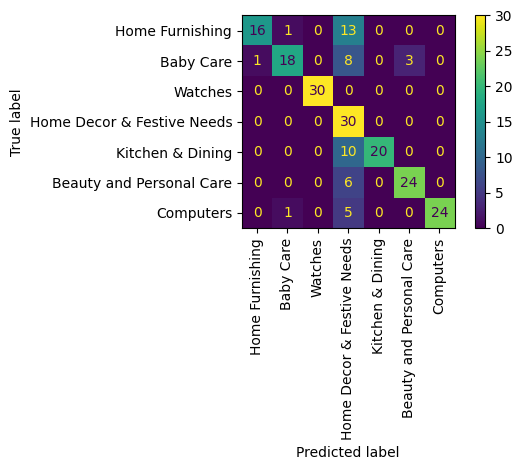

In [52]:
cm_zero_shot = confusion_matrix(y_true=df_test["main_product_category"],
                                 y_pred=df_test["zero_shot"],
                                 labels=MAIN_PRODUCT_CATEGORIES)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_zero_shot,
                              display_labels=MAIN_PRODUCT_CATEGORIES)

disp.plot()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 3.3.2 Perfs avec explications des labels

In [34]:
cr_zero_shot_labels_explained = classification_report(y_true=df_test["main_product_category"],
                                                      y_pred=df_test["zero_shot_labels_explained"])

print(cr_zero_shot_labels_explained)

                            precision    recall  f1-score   support

                 Baby Care       0.95      0.63      0.76        30
  Beauty and Personal Care       0.92      0.77      0.84        30
                 Computers       0.97      0.93      0.95        30
Home Decor & Festive Needs       0.58      1.00      0.73        30
           Home Furnishing       0.93      0.83      0.88        30
          Kitchen & Dining       1.00      0.90      0.95        30
                   Watches       1.00      1.00      1.00        30

                  accuracy                           0.87       210
                 macro avg       0.91      0.87      0.87       210
              weighted avg       0.91      0.87      0.87       210



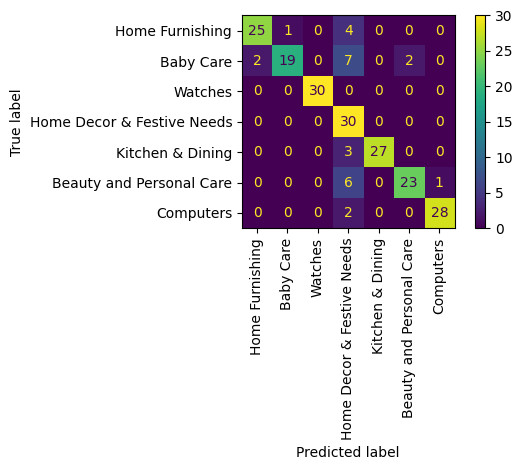

In [53]:
cm_zero_shot_labels_explained = confusion_matrix(y_true=df_test["main_product_category"],
                                 y_pred=df_test["zero_shot_labels_explained"],
                                 labels=MAIN_PRODUCT_CATEGORIES)

disp_labels_explained = ConfusionMatrixDisplay(confusion_matrix=cm_zero_shot_labels_explained,
                              display_labels=MAIN_PRODUCT_CATEGORIES)
disp_labels_explained.plot()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()